# nolearn

In [32]:
from __future__      import division
from IPython.display import display
from matplotlib      import pyplot as plt
%matplotlib inline

import numpy  as np
import pandas as pd
import random, sys, os

from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search      import RandomizedSearchCV, GridSearchCV

In [33]:
SEED   = 97
scale  = True 
minmax = False
norm   = False
nointercept = True
engineering = False

N_CLASSES = 2

submission_filename = "../submissions/submission_nolearn.csv"

In [34]:
global early_stop_type
early_stop_type = 'unset'

In [35]:
import theano
from theano import tensor as T

import lasagne
from lasagne                import layers, nonlinearities
from lasagne.nonlinearities import rectify, softmax, sigmoid
from lasagne.updates        import nesterov_momentum, adam, adagrad, rmsprop
from lasagne.layers         import InputLayer, DenseLayer, DropoutLayer
from lasagne.layers         import get_all_params

try:
    from lasagne.layers.cuda_covnet import Conv2DCCLayer    as Conv2DLayer
    from lasagne.layers.cuda_covnet import MaxPool2DCCLayer as MaxPool2DLayer
    from lasagne.layers             import Pool2DLayer
    print("Conv2DCCLayer and MaxPool2DCCLayer used")
    DCC = True
except ImportError:
    print("ImportError: Conv2DLayer and MaxPool2DLayer used")
    DCC = False
    Conv2DLayer    = lasagne.layers.Conv2DLayer
    MaxPool2DLayer = lasagne.layers.MaxPool2DLayer
    Pool2DLayer    = lasagne.layers.Pool2DLayer

ImportError: Conv2DLayer and MaxPool2DLayer used


In [36]:
from nolearn.lasagne           import NeuralNet, TrainSplit, BatchIterator
from nolearn.lasagne           import objective
from nolearn.lasagne           import PrintLayerInfo

from nolearn.lasagne.visualize import plot_loss
from nolearn.lasagne.visualize import plot_conv_weights
from nolearn.lasagne.visualize import plot_conv_activity
from nolearn.lasagne.visualize import plot_occlusion

In [37]:
print theano.config.device

cpu


# Load the training data

In [38]:
from load_blood_data import load_blood_data

y_train, X_train = load_blood_data(train=True, SEED   = SEED, 
                                               scale  = scale,
                                               minmax = minmax,
                                               norm   = norm,
                                               nointercept = nointercept,
                                               engineering = engineering)

# Fit the model

In [39]:
"""
[Using convolutional neural nets to detect facial keypoints; Daniel Nouri]
"""

def float32(k):
    """
    Cast a variable for inclusion in a theano.shared variable
    for subsequent use by AdjustVariable
    """
    return np.cast['float32'](k)

class AdjustVariable(object):
    """
    Change the 'name' parameter each epoch
    on a linspace(start, stop) schedule
    """
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)
        
class EarlyStopping_loss(object):
    """
    Stop the training process if the validation loss has not declined
    for 'patience' epochs
    The model returned has the weights from the epoch with the lowest validation loss.
    """
    def __init__(self, patience=100):
        self.patience         = patience
        self.best_valid       = np.inf
        self.best_valid_epoch = 0
        self.best_weights     = None
        global early_stop_type
        early_stop_type = 'loss'
        

    def __call__(self, nn, train_history):
        current_valid = train_history[-1]['valid_loss']
        current_epoch = train_history[-1]['epoch']
        if current_valid < self.best_valid:
            self.best_valid = current_valid
            self.best_valid_epoch = current_epoch
            self.best_weights = nn.get_all_params_values()
        elif self.best_valid_epoch + self.patience < current_epoch:
            print("\nEarly stopping.")
            print("Best valid loss was {:.6f} at epoch {}.\n".format(
                self.best_valid, self.best_valid_epoch))
            nn.load_params_from(self.best_weights)
            raise StopIteration()
            
class EarlyStopping_acc(object):
    """
    Stop the training process if the validation accuracy has not increased
    for 'patience' epochs
    The model returned has the weights from the epoch with the highest validation accuracy.
    """
    def __init__(self, patience=100):
        self.patience         = patience
        self.best_valid_acc   = 0
        self.best_valid_epoch = 0
        self.best_weights     = None
        global early_stop_type
        early_stop_type = 'acc'
        

    def __call__(self, nn, train_history):
        global early_stop
        current_valid_acc = train_history[-1]['valid_accuracy']
        current_epoch     = train_history[-1]['epoch']
        if current_valid_acc > self.best_valid_acc:
            self.best_valid_acc   = current_valid_acc
            self.best_valid_epoch = current_epoch
            self.best_weights     = nn.get_all_params_values()
        elif self.best_valid_epoch + self.patience < current_epoch:
            print("\nEarly stopping.")
            print("Best valid accuracy was {:.6f} at epoch {}.\n".format(
                self.best_valid_acc, self.best_valid_epoch))
            nn.load_params_from(self.best_weights)
            raise StopIteration()
            
def elastic_net(layers, lambdaL1=0., lambdaL2=0., *args, **kwargs):
    losses = objective(layers, *args, **kwargs)
    # get the layers' weights, but not the biases
    weights = get_all_params(layers[-1], regularizable=True)
    # sum of absolute weights for L1
    sum_abs_weights = sum([abs(w).sum() for w in weights])
    # sum of squared weights for L2
    sum_squared_weights = sum([(w ** 2).sum() for w in weights])
    # add weights to regular loss
    losses += lambdaL1 * sum_abs_weights + lambdaL2 * sum_squared_weights
    return losses

class FlipBatchIterator(BatchIterator):

    def transform(self, Xb, yb):
        Xb, yb = super(FlipBatchIterator, self).transform(Xb, yb)

        # Flip half of the images in this batch at random:
        bs = Xb.shape[0]
        indices = np.random.choice(bs, bs / 2, replace=False)
        Xb[indices] = Xb[indices, :, :, ::-1]

        return Xb, yb

In [40]:
"""
[Understanding the difficulty of training deep feedforward neural networks; Xavier Glorot, Yoshua Bengio]
"""

def xavierReLU(fan_in,fan_out):
    """
    Xavier Glorot and Yohua Bengio recommended weight initialization
    for layers using a ReLU activation function
    
    W ~ U[ +/- sqrt(6 / (fan_in + fan_out)) ]
    """
    import numpy as np
    return np.sqrt(6. / (fan_in + fan_out))

def xavierTanH(fan_in,fan_out):
    """
    Xavier Glorot and Yohua Bengio recommended weight initialization
    for layers using a tanh activation function
    
    W ~ U[ +/- 4 * sqrt(6 / (fan_in + fan_out)) ]
    """
    import numpy as np
    return 4. * np.sqrt(6. / (fan_in + fan_out))

In [41]:
%%time
"""
[Neural Networks and Deep Learning; Michael Nielsen ]
"""

random.seed(SEED)


clf_layers=[
            ('input',    InputLayer),
    
    
#             ('dropout1', DropoutLayer),
            ('dense1',   DenseLayer),
    
#             ('dropout2', DropoutLayer),
#             ('dense2',   DenseLayer),
    

            ('output',   DenseLayer),
            ]



clf = NeuralNet(
    
    layers=clf_layers,
    
    regression=False,
    
    # --------------------------------------------------------------------------
    
    input_shape=(None, X_train.shape[1]), 
    
    # Fully Connected
    # ===============
#     dropout1_p=0.20,
    
    dense1_num_units    = 500,
    dense1_nonlinearity = lasagne.nonlinearities.LeakyRectify(leakiness=1./3.),
    dense1_W = lasagne.init.Uniform(range = xavierReLU(X_train.shape[1], 500)),
    dense1_b = lasagne.init.Constant(1.),
    
#     dropout2_p=0.02,
    
#     dense2_num_units    = 10,
#     dense2_nonlinearity = lasagne.nonlinearities.LeakyRectify(leakiness=1./3.),
#     dense2_W = lasagne.init.Uniform(range = xavierReLU(500, 10)),
#     dense2_b = lasagne.init.Constant(1.),
    

    # Output
    # ======
    output_num_units    = N_CLASSES, 
    output_nonlinearity = nonlinearities.softmax,
    output_W = lasagne.init.Normal(std=1./np.sqrt(500 + N_CLASSES), mean=0.0),
    output_b = lasagne.init.Constant(1.),
    
    # --------------------------------------------------------------------------
    
    # Loss Function
    # =============
    objective_loss_function = lasagne.objectives.categorical_crossentropy,
    
    # L1 & L2 Regularization
    # ======================
    objective          = elastic_net,
    objective_lambdaL1 = 0.0000,
    objective_lambdaL2 = 0.0000,
    
    # Update Function
    # ===============
    update               = lasagne.updates.momentum,
    update_learning_rate = theano.shared(float32(0.003)),
    update_momentum      = theano.shared(float32(0.9)),
    
    # Early Stopping
    # ==============
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.003,  stop=0.0003),
        AdjustVariable('update_momentum',      start=0.9,    stop=0.99),
        
        EarlyStopping_loss(patience = 50)
        ],
    
    
    # Mini-Batch Size
    # ===============
    batch_iterator_train = BatchIterator(batch_size=1), 
    batch_iterator_test  = BatchIterator(batch_size=1),

    # Max Epochs
    # ==========
    max_epochs = 100,
    
    verbose=0,
    train_split=TrainSplit(0.2, stratify=True)
    )



CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 295 µs


In [42]:
%%time

clf.initialize()
layer_info = PrintLayerInfo()
layer_info(clf, None)

# Neural Network with 4002 learnable parameters

## Layer information

  #  name      size
---  ------  ------
  0  input        5
  1  dense1     500
  2  output       2

CPU times: user 404 ms, sys: 8 ms, total: 412 ms
Wall time: 409 ms


In [43]:
# clf_params = {'verbose': 0, 'n_estimators': 10, 'criterion': 'gini'}
# clf.set_params(**clf_params)
clf.fit(X_train.values.astype(np.float32), y_train)


Early stopping.
Best valid loss was 0.549808 at epoch 25.



NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f3b006e4250>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f3b006e4a50>,
     custom_score=None,
     dense1_W=<lasagne.init.Uniform object at 0x7f3b006e4450>,
     dense1_b=<lasagne.init.Constant object at 0x7f3b006e4950>,
     dense1_nonlinearity=<lasagne.nonlinearities.LeakyRectify object at 0x7f3b006e4610>,
     dense1_num_units=500, input_shape=(None, 5),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('dense1', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=100, more_params={},
     objective=<function elastic_net at 0x7f3b1e848f50>,
     objective_lambdaL1=0.0, objective_lambdaL2=0.0,
     objective_loss_function=<function categorical_crossentropy at 0x7f3b08c6f488>,
     on_epoch_finished=[<__main__.AdjustVariable object at 0x7f3b006e4550>, <__main

In [44]:
# =================================
# Create vectors of loss & accuracy
# =================================
train_loss = np.array([i["train_loss"]     for i in clf.train_history_])
valid_loss = np.array([i["valid_loss"]     for i in clf.train_history_])
valid_acc  = np.array([i["valid_accuracy"] for i in clf.train_history_])

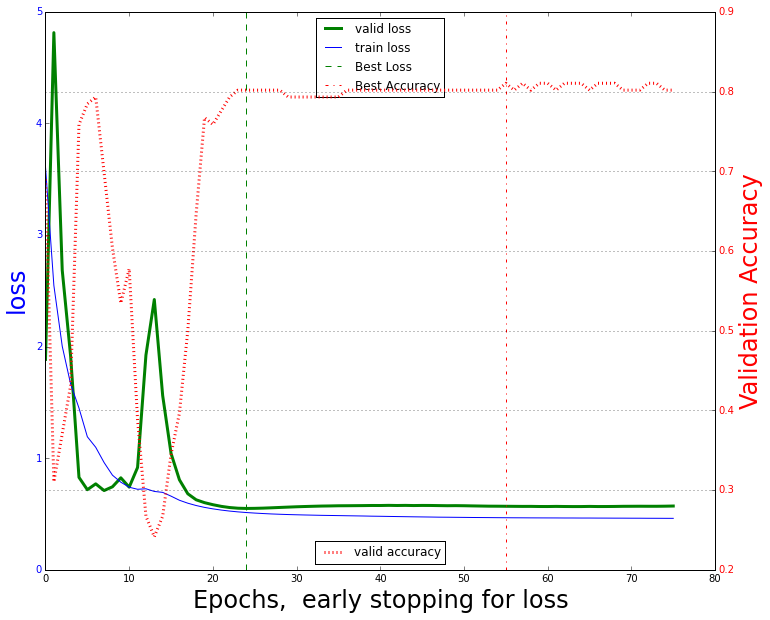

In [45]:
fig, ax1 = plt.subplots(figsize=(12,10))

# ===============================
# Plot Validation & Training Loss
# ===============================
ax1.plot(valid_loss, linewidth=3, label="valid loss", color='g', linestyle='-')
ax1.plot(train_loss, linewidth=1, label="train loss", color='b', linestyle='-')
stop_type = ' no early stopping' 
if early_stop_type=='acc':  stop_type = ' early stopping for accuracy'
if early_stop_type=='loss': stop_type = ' early stopping for loss'
ax1.set_xlabel('Epochs, '+stop_type,fontsize=24)

# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('loss', color='b',fontsize=24)
for tl in ax1.get_yticklabels():
    tl.set_color('b')
    
#plt.yscale("log")
#-----------------

ax1.axvline(np.argmin(valid_loss)+0, color='g', linestyle='--',label="Best Loss")
ax1.axvline(np.argmax(valid_acc)+0,  color='r', linestyle='-.',label="Best Accuracy")
ax1.legend(loc="upper center")

# ========================
# Plot Validation Accuracy
# ========================
ax2 = ax1.twinx()  # share the x axis
ax2.plot(valid_acc, linewidth=3, label="valid accuracy", color='r',linestyle=':')
ax2.set_ylabel('Validation Accuracy', color='r',fontsize=24)

# Make the y-axis label and tick labels match the line color.
for tl in ax2.get_yticklabels():
    tl.set_color('r')
ax2.legend(loc="lower center")

plt.grid()
plt.show()

# Training set predictions

In [46]:
predicted_values = clf.predict(X_train.values.astype(np.float32))
y_true, y_pred   = y_train, predicted_values

predicted_probs  = clf.predict_proba(X_train.values.astype(np.float32))

[[409  29]
 [ 82  56]]


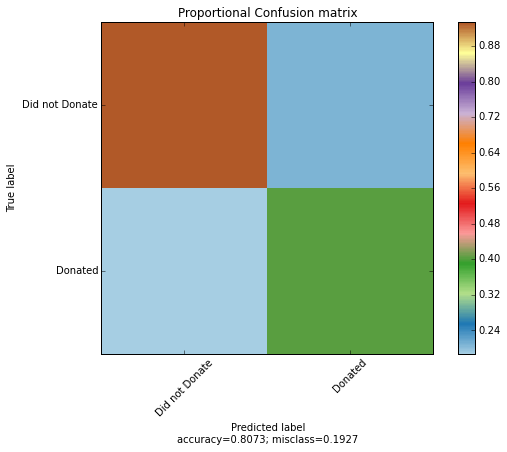

Accuracy 0.8073, mis-class rate 0.1927


In [47]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred, labels=None)
print cm

try:
    from sklearn_utilities import plot_confusion_matrix
except:
    import imp, os
    util = imp.load_source('sklearn_utilities', os.path.expanduser('~/Dropbox/Python/sklearn_utilities.py'))
    from sklearn_utilities import plot_confusion_matrix


plot_confusion_matrix(cm, ['Did not Donate','Donated'])

accuracy = round(np.trace(cm)/float(np.sum(cm)),4)
misclass = 1 - accuracy
print("Accuracy {}, mis-class rate {}".format(accuracy,misclass))

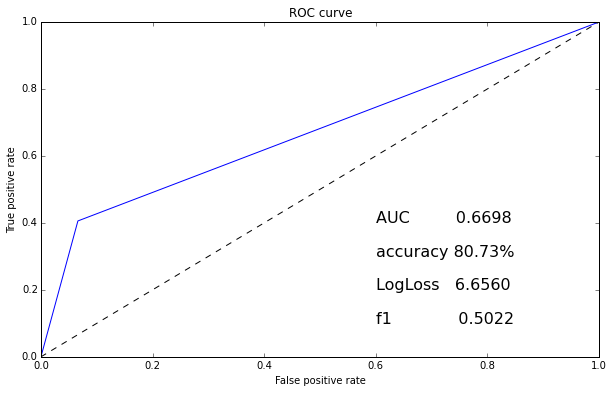

In [48]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score

fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=None)


plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)

AUC = roc_auc_score(y_true, y_pred, average='macro')
plt.text(x=0.6,y=0.4,s="AUC         {:.4f}"\
         .format(AUC),
        fontsize=16)

plt.text(x=0.6,y=0.3,s="accuracy {:.2f}%"\
         .format(accuracy*100),
        fontsize=16)

logloss = log_loss(y_true, y_pred)
plt.text(x=0.6,y=0.2,s="LogLoss   {:.4f}"\
         .format(logloss),
        fontsize=16)

f1 = f1_score(y_true, y_pred)
plt.text(x=0.6,y=0.1,s="f1             {:.4f}"\
         .format(f1),
        fontsize=16)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [49]:
# format for scores.csv file
import re
algo = re.search(r"submission_(.*?)\.csv", submission_filename).group(1)
print("{: <26} ,        ,   {:.4f} ,  {:.4f} , {:.4f} , {:.4f} ,  , "\
      .format(algo,accuracy,logloss,AUC,f1))

nolearn                    ,        ,   0.8073 ,  6.6560 , 0.6698 , 0.5022


#### confirm that *sklearn.metrics.log_loss* conforms to the contest formula

In [50]:
def log_loss(y_true, y_pred):
    """
    logloss formula
    """
    import scipy
    import math
    
    assert len(y_true)==len(y_pred)
    
    n     = len(y_true)
    comps = []
    
    # prevent log(0/1): y_pred \in [epsilon, 0.999]
    epsilon = 1e-15
    y_pred = scipy.maximum(epsilon, y_pred)
    y_pred = scipy.minimum(1-epsilon, y_pred)
    
    for i in range(n):
        comp1 =    y_true[i]    * math.log(  y_pred[i],     math.e)
        comp2 = (1 - y_true[i]) * math.log((1 - y_pred[i]), math.e)
        comps.append(comp1+comp2)
    
    return round(-sum(comps)/float(n),4)

log_loss(y_true,y_pred)

6.656

# --------------------------------------------------------------------------------------------

# Test Set Predictions

## Read the test data

In [51]:
from load_blood_data import load_blood_data

X_test, IDs = load_blood_data(train=False, SEED   = SEED, 
                                           scale  = scale,
                                           minmax = minmax,
                                           norm   = norm,
                                           nointercept = nointercept,
                                           engineering = engineering)

# Predict the test set with the fitted model

In [52]:
y_pred        = clf.predict(X_test.values.astype(np.float32))
y_pred_probs  = clf.predict_proba(X_test.values.astype(np.float32))
donate_probs  = [prob[1] for prob in y_pred_probs]

In [53]:
print(y_pred[:10])
print(y_pred_probs[:10])
print(donate_probs[:10])

[1 0 0 0 1 1 0 0 0 0]
[[ 0.48901987  0.51098013]
 [ 0.88643295  0.11356703]
 [ 0.69935817  0.30064186]
 [ 0.64642584  0.35357416]
 [ 0.44492528  0.55507475]
 [ 0.4067255   0.59327453]
 [ 0.64343876  0.35656124]
 [ 0.78362268  0.21637732]
 [ 0.99497014  0.00502988]
 [ 0.91420865  0.08579135]]
[0.51098013, 0.11356703, 0.30064186, 0.35357416, 0.55507475, 0.59327453, 0.35656124, 0.21637732, 0.0050298837, 0.085791349]


# Create the submission file

In [78]:
assert len(IDs)==len(donate_probs)

f = open(submission_filename, "w")

f.write(",Made Donation in March 2007\n")
for ID, prob in zip(IDs, donate_probs):
    f.write("{},{}\n".format(ID,prob))
    
f.close()